# ST311 Summative assignment

https://colab.research.google.com/drive/1aUJZukmQD4Kv6IVgt-7e3nUiZKsKkvr6?usp=sharing

**Preface:**

*   *All data values will be given rounded to 3 decimal places when in writing*
*   *Validation accuracy will be used throughout in order to give the best idea of how the models and techniques work relative to eachother*



**1.A**

### Importing and gpu check

*Importing necessary libraries*

In [46]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.optim as optim   # SGD
import time

*Checking if a GPU is available. The program will run using the GPU if it's available, otherwise it will use the CPU.*

In [47]:
cuda = torch.cuda.is_available()
cuda   # returns a Boolean indicating availability of GPU

False

## The Kuzushiji-MNIST data:

*getting and viewing the data*

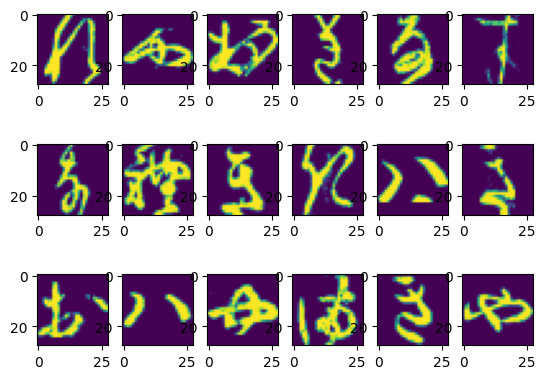

In [48]:
mnist_images = datasets.KMNIST('data', train=True, download=True)   # downloading the data

for k, (image, label) in enumerate(mnist_images):   # viewing some of the data
    if k >= 18:
        break
    plt.subplot(3, 6, k+1)
    plt.imshow(image)

Convert to images to tensor format. The data has been downloaded in the previous code chunk `download=True`, so no need to download again here.

In [49]:
mnist_train = datasets.KMNIST('data', train=True, transform=transforms.ToTensor())
mnist_train = list(mnist_train)   # creating training data
mnist_val = datasets.KMNIST('data', train=False, transform=transforms.ToTensor())
mnist_val = list(mnist_val)   # creating validation data

print(mnist_train[0][0].shape)   # checking image size

torch.Size([1, 28, 28])


## Creating the models

In [50]:
# Plain NN (3-layers)

model = nn.Sequential(nn.Flatten(),
                      nn.Linear(28*28, 256),
                      nn.ReLU(),
                      nn.Linear(256, 256),
                      nn.ReLU(),
                      nn.Linear(256, 10))

# NN with dropout (after ReLU)

model_drop = nn.Sequential(nn.Flatten(),
                           nn.Linear(28*28, 256),
                           nn.ReLU(),
                           nn.Dropout(),   # keeping p=0.5
                           nn.Linear(256, 256),
                           nn.ReLU(),
                           nn.Linear(256, 10))

# NN with batchnorm (before the ReLU)

model_bn = nn.Sequential(nn.Flatten(),
                         nn.Linear(28*28, 256),
                         nn.BatchNorm1d(256),
                         nn.ReLU(),
                         nn.Linear(256, 256),
                         nn.BatchNorm1d(256),
                         nn.ReLU(),
                         nn.Linear(256, 10))

# 3-layer NN with dropout and batchnorm

model_both = nn.Sequential(nn.Flatten(),
                           nn.Linear(28*28, 256),
                           nn.BatchNorm1d(256),
                           nn.ReLU(),
                           nn.Dropout(),   # keeping p=0.5
                           nn.Linear(256, 256),
                           nn.BatchNorm1d(256),
                           nn.ReLU(),
                           nn.Linear(256, 10))

# 5-layer NN with dropout and batchnorm (created after deciding to use dropout and batchnorm)

model_five_layer = nn.Sequential(nn.Flatten(),
                                 nn.Linear(28*28, 512),
                                 nn.BatchNorm1d(512),
                                 nn.ReLU(),
                                 nn.Dropout(),   # keeping p=0.5
                                 nn.Linear(512, 512),
                                 nn.BatchNorm1d(512),
                                 nn.ReLU(),
                                 nn.Dropout(),
                                 nn.Linear(512, 256),
                                 nn.BatchNorm1d(256),
                                 nn.ReLU(),
                                 nn.Dropout(),
                                 nn.Linear(256, 256),
                                 nn.BatchNorm1d(256),
                                 nn.ReLU(),
                                 nn.Linear(256, 10))

Initialising weights


In [51]:
# chosen init to help avoid vanishing/exploding gradient problem and improve efficiency
def init_weights(m):
    "Initialise weights to the linear layer"
    if type(m) == nn.Linear:
        # nn.init.normal_(tensor=m.weight, mean=0.0,std=0.001)
        # nn.init.xavier_normal_(tensor=m.weight)
        # nn.init.xavier_uniform_(tensor=m.weight)
        # nn.init.kaiming_normal_(tensor=m.weight)
        nn.init.kaiming_uniform_(tensor=m.weight)
          # to avoid the dead neuron problem (as ReLU outputs zero for negative number)

# applying weight initialisation to the models
model.apply(init_weights)
model_drop.apply(init_weights)
model_bn.apply(init_weights)
model_both.apply(init_weights)
model_five_layer.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=512, out_features=512, bias=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=512, out_features=256, bias=True)
  (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Dropout(p=0.5, inplace=False)
  (13): Linear(in_features=256, out_features=256, bias=True)
  (14): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): ReLU()
  (16): Linear(in_features=256, out_features=10, bias=True)
)

Setting up device to do computation (device is either cpu or gpu)

In [52]:
# choosing between gpu and cpu depending on gpu availability (cuda)
device = torch.device("cuda" if cuda else "cpu")

# transfer model to device (transferring data to device in later code chunk)
model.to(device)
model_drop.to(device)
model_bn.to(device)
model_both.to(device)
model_five_layer.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=512, out_features=512, bias=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=512, out_features=256, bias=True)
  (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Dropout(p=0.5, inplace=False)
  (13): Linear(in_features=256, out_features=256, bias=True)
  (14): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): ReLU()
  (16): Linear(in_features=256, out_features=10, bias=True)
)

## Training

### Creating training function

In [53]:
def train(model, data, batch_size=64, num_epochs=1, lr_choice=0.01, grad_clip=1.0):

    # Dataloader creates and iterator and fetches minibatches as needed
    train_loader = torch.utils.data.DataLoader(data,batch_size=batch_size,
                                               shuffle=True)

    # Pick loss and optimiser to use in training
    ## Inialise loss
    criterion = nn.CrossEntropyLoss()   # chosen loss function as it's very good for image classification

    ## Initialise optimizer (SGD vs SGD with momentum(=0.9) vs AdamW)
    # optimizer = optim.SGD(model.parameters(), weight_decay=0.01, lr=lr_choice)
    # optimizer = optim.SGD(model.parameters(), weight_decay=0.01, lr=lr_choice, momentum=0.9)
    optimizer = optim.AdamW(model.parameters(), lr=lr_choice)   # weight_decay=0.01 by default
      # performs best - porbably due to the adaptive learning rate and weight decay

    # Store evaluation metrics
    epch, losses, train_acc, val_acc = [], [], [], []

    # Training loop
    n = 0 # the number of epochs

    start_time = time.time()

    for epoch in range(num_epochs):

        model.train()   # training mode
        running_loss = 0.0

        # Iterate over the minibatches
        for imgs, labels in train_loader:

            # Transfer data to device
            imgs, labels = imgs.to(device), labels.to(device)

            # Forward pass: outputs logits for each image and computes the loss value
            out = model(imgs)
            loss = criterion(out, labels)

            running_loss += loss.item()   # record sum of losses over mini-batches in the current epoch

            # Backward pass and update
            optimizer.zero_grad()                               # reset gradients
            loss.backward()                                     # backprop
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)   # clipping gradient
            optimizer.step()                                    # update each parameter




        # End of an epoch
        n += 1
        epch.append(n)
        losses.append(running_loss)
        train_acc.append(get_accuracy(model, train=True))   # compute training accuracy
        val_acc.append(get_accuracy(model, train=False))    # compute validation accuracy
        end_time = time.time()

        training_metric = (
          f'Epoch {epoch+1}/{num_epochs}, Training loss(ave. loss per minibatch): {round(running_loss/len(train_loader),2)},'\
          f'Time: {round(end_time - start_time,5)}s')
        print(training_metric)

    # Plotting
    plt.title("Training Curve")
    plt.plot(epch, losses, label="Train")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epch, train_acc, label="Train")
    plt.plot(epch, val_acc, label="Validation")
    plt.xlabel("epochs")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

`get_accuracy` helper function

In [54]:
## to turn the probabilities into a discrete prediction, we will take the digit
## with the highest probability. Because of the way softmax is computed, the
## digit with the highest probability is the same as the digit with the
## (pre-activation) output value.

def get_accuracy(model, train=False, batch_size = 64):
    """
    Computes the accuracy of the training data (train=True), and validation
    data (train=False). Accuracy is defined as number correct predictions/ Total
    number of predictions made.

    This function is called from inside the training loop.

    Returns accuracy, a scalar.
    """
    model.eval()   # set model to evaluation mode

    data = mnist_train if train else mnist_val

    correct, total = 0, 0

    with torch.no_grad():
          for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size):
              # Transfer data to device
              imgs, labels = imgs.to(device), labels.to(device)

              output = model(imgs)
              pred = output.argmax(dim=1)   # index of class with highest probability
              correct += (pred == labels).sum().item()
              total += labels.size(0)

    return correct / total

### Debugging

Epoch 1/4, Training loss(ave. loss per minibatch): 2.57,Time: 0.83353s
Epoch 2/4, Training loss(ave. loss per minibatch): 1.62,Time: 1.62928s
Epoch 3/4, Training loss(ave. loss per minibatch): 2.89,Time: 2.4233s
Epoch 4/4, Training loss(ave. loss per minibatch): 1.54,Time: 3.21156s


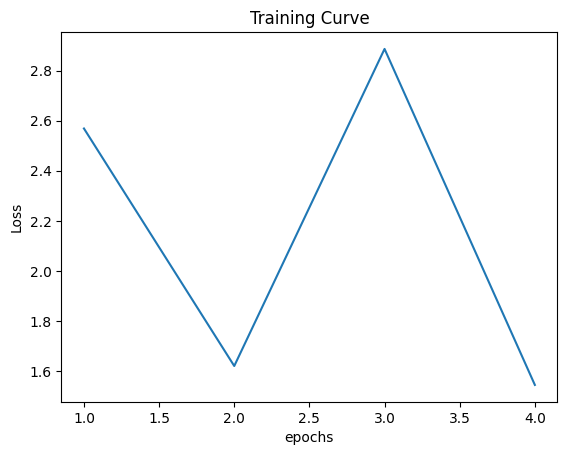

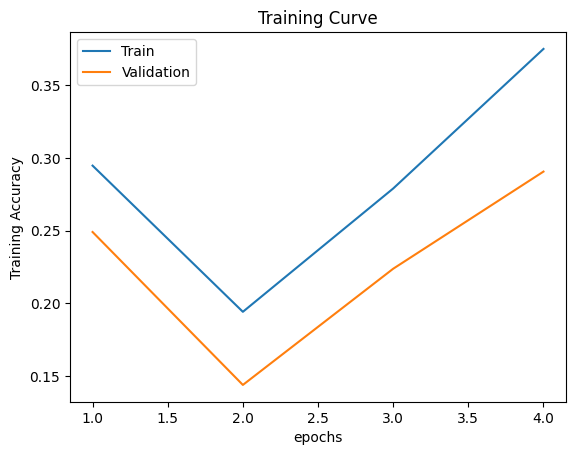

Final Training Accuracy: 0.37516666666666665
Final Validation Accuracy: 0.2907
Epoch 1/4, Training loss(ave. loss per minibatch): 2.44,Time: 0.82438s
Epoch 2/4, Training loss(ave. loss per minibatch): 2.64,Time: 1.64198s
Epoch 3/4, Training loss(ave. loss per minibatch): 2.08,Time: 2.45701s
Epoch 4/4, Training loss(ave. loss per minibatch): 1.03,Time: 3.26797s


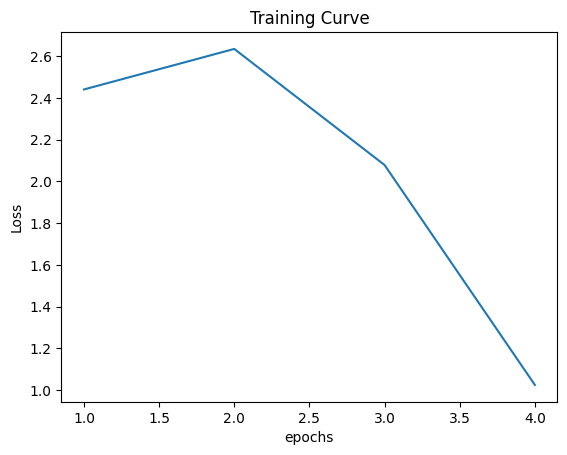

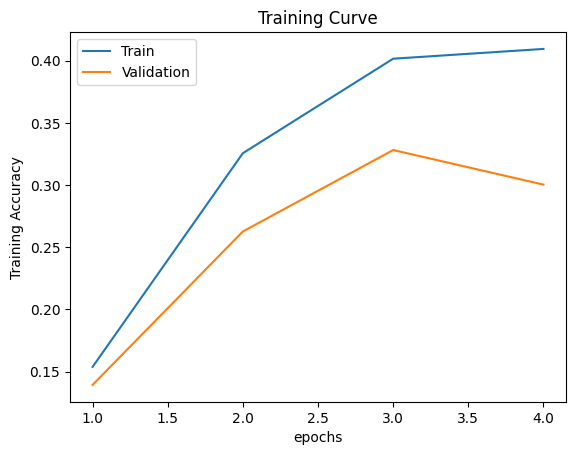

Final Training Accuracy: 0.40951666666666664
Final Validation Accuracy: 0.3004
Epoch 1/4, Training loss(ave. loss per minibatch): 2.56,Time: 0.88993s
Epoch 2/4, Training loss(ave. loss per minibatch): 0.17,Time: 1.94918s
Epoch 3/4, Training loss(ave. loss per minibatch): 0.04,Time: 3.05648s
Epoch 4/4, Training loss(ave. loss per minibatch): 0.01,Time: 3.9331s


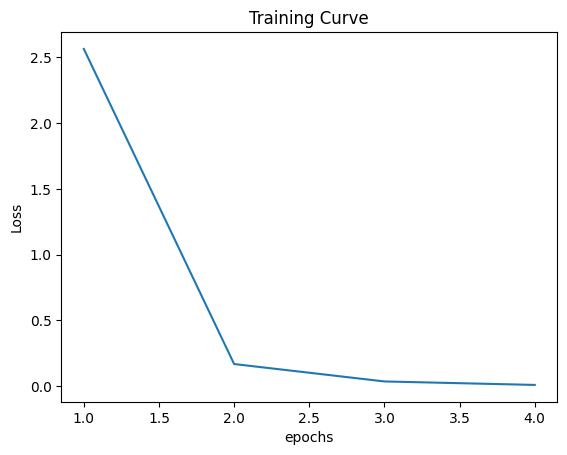

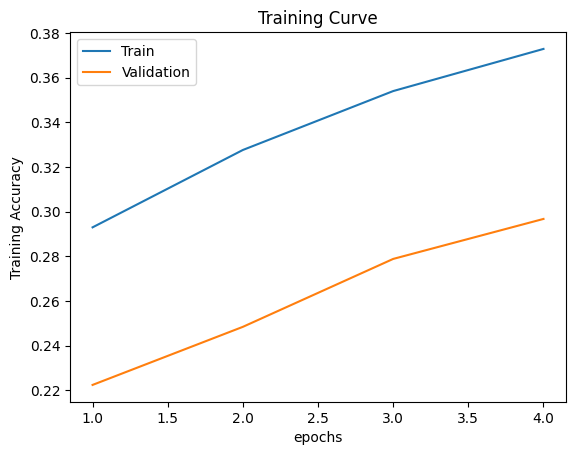

Final Training Accuracy: 0.3728
Final Validation Accuracy: 0.2967
Epoch 1/4, Training loss(ave. loss per minibatch): 2.71,Time: 0.8821s
Epoch 2/4, Training loss(ave. loss per minibatch): 0.72,Time: 1.78956s
Epoch 3/4, Training loss(ave. loss per minibatch): 0.46,Time: 2.68372s
Epoch 4/4, Training loss(ave. loss per minibatch): 0.21,Time: 3.56657s


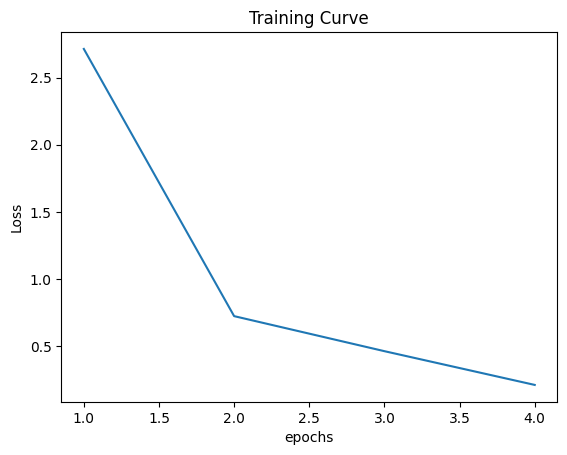

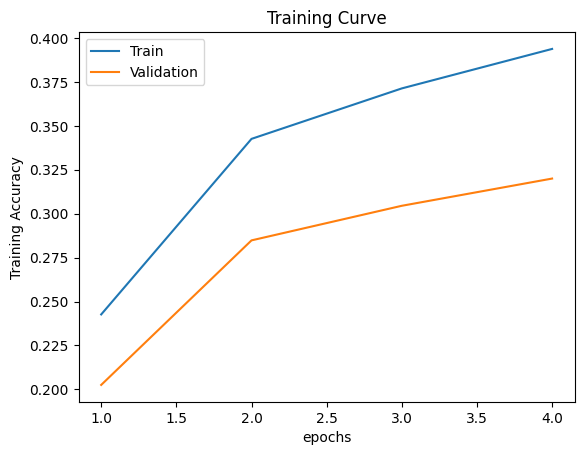

Final Training Accuracy: 0.39381666666666665
Final Validation Accuracy: 0.32
Epoch 1/4, Training loss(ave. loss per minibatch): 2.64,Time: 2.47036s
Epoch 2/4, Training loss(ave. loss per minibatch): 2.23,Time: 5.01404s
Epoch 3/4, Training loss(ave. loss per minibatch): 1.74,Time: 7.73485s
Epoch 4/4, Training loss(ave. loss per minibatch): 1.43,Time: 10.23883s


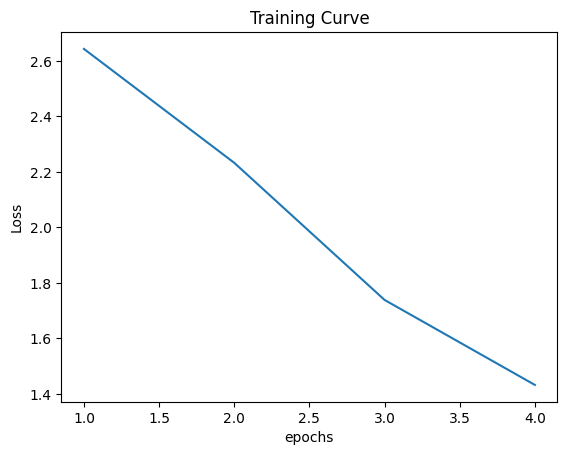

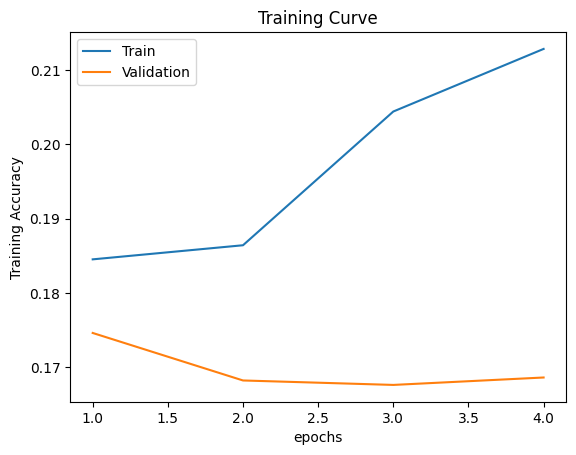

Final Training Accuracy: 0.21286666666666668
Final Validation Accuracy: 0.1686


In [55]:
debug_data = mnist_train[:64] #sample size = batch size
train(model, debug_data, num_epochs=4)
train(model_drop, debug_data, num_epochs=4)
train(model_bn, debug_data, num_epochs=4)
train(model_both, debug_data, num_epochs=4)
train(model_five_layer, debug_data, num_epochs=4)

### Hyper parameter Tuning (on all models by replacing model_both with other models)

In [56]:
# creating a function to reset the models' learned parameters
def reset_mod_params(model):
  for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
      layer.reset_parameters()

rate: 0.0005
Epoch 1/16, Training loss(ave. loss per minibatch): 0.98,Time: 1.55583s
Epoch 2/16, Training loss(ave. loss per minibatch): 0.54,Time: 3.15213s
Epoch 3/16, Training loss(ave. loss per minibatch): 0.44,Time: 4.75412s
Epoch 4/16, Training loss(ave. loss per minibatch): 0.37,Time: 6.76274s
Epoch 5/16, Training loss(ave. loss per minibatch): 0.33,Time: 8.30523s
Epoch 6/16, Training loss(ave. loss per minibatch): 0.3,Time: 9.8585s
Epoch 7/16, Training loss(ave. loss per minibatch): 0.27,Time: 11.44885s
Epoch 8/16, Training loss(ave. loss per minibatch): 0.25,Time: 13.00263s
Epoch 9/16, Training loss(ave. loss per minibatch): 0.23,Time: 14.53454s
Epoch 10/16, Training loss(ave. loss per minibatch): 0.21,Time: 16.03562s
Epoch 11/16, Training loss(ave. loss per minibatch): 0.19,Time: 17.87832s
Epoch 12/16, Training loss(ave. loss per minibatch): 0.19,Time: 19.47709s
Epoch 13/16, Training loss(ave. loss per minibatch): 0.17,Time: 21.0507s
Epoch 14/16, Training loss(ave. loss per mi

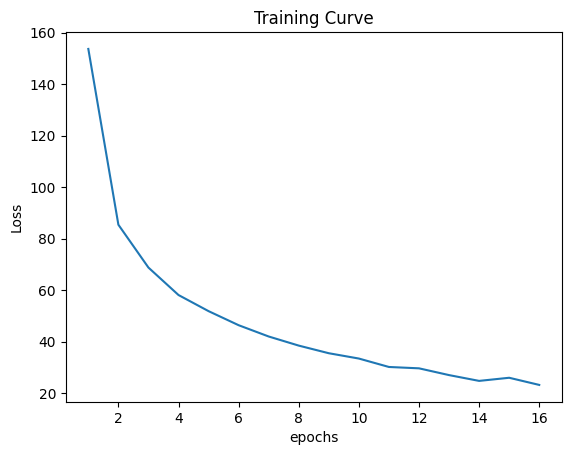

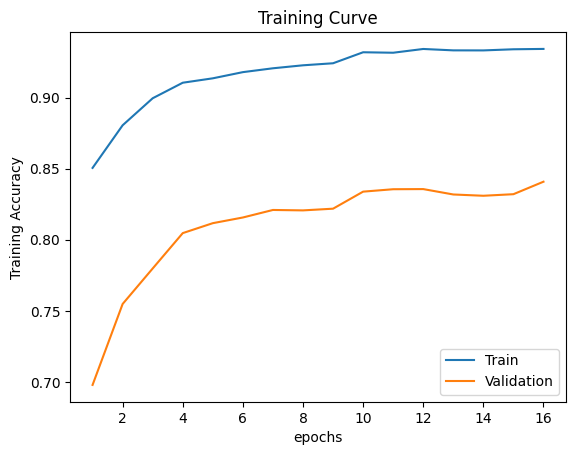

Final Training Accuracy: 0.9344
Final Validation Accuracy: 0.8409
rate: 0.001
Epoch 1/16, Training loss(ave. loss per minibatch): 0.82,Time: 1.97797s
Epoch 2/16, Training loss(ave. loss per minibatch): 0.49,Time: 3.88756s
Epoch 3/16, Training loss(ave. loss per minibatch): 0.4,Time: 5.47921s
Epoch 4/16, Training loss(ave. loss per minibatch): 0.35,Time: 7.04318s
Epoch 5/16, Training loss(ave. loss per minibatch): 0.32,Time: 8.66835s
Epoch 6/16, Training loss(ave. loss per minibatch): 0.29,Time: 10.20912s
Epoch 7/16, Training loss(ave. loss per minibatch): 0.24,Time: 11.75268s
Epoch 8/16, Training loss(ave. loss per minibatch): 0.22,Time: 13.38947s
Epoch 9/16, Training loss(ave. loss per minibatch): 0.21,Time: 15.2465s
Epoch 10/16, Training loss(ave. loss per minibatch): 0.2,Time: 16.86348s
Epoch 11/16, Training loss(ave. loss per minibatch): 0.17,Time: 18.40731s
Epoch 12/16, Training loss(ave. loss per minibatch): 0.17,Time: 19.92417s
Epoch 13/16, Training loss(ave. loss per minibatch)

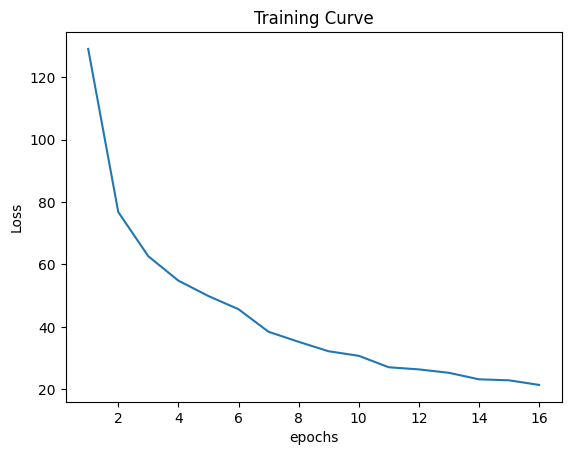

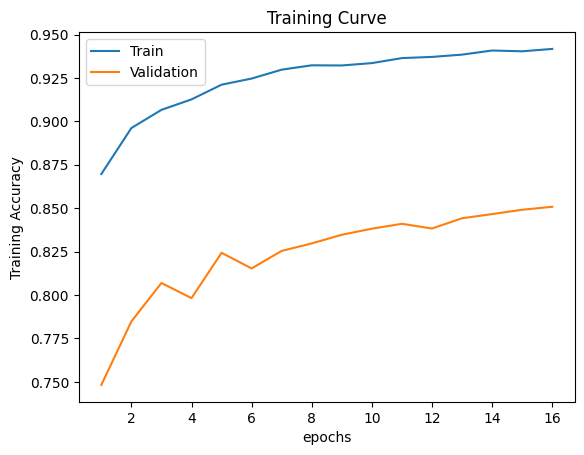

Final Training Accuracy: 0.9417333333333333
Final Validation Accuracy: 0.8508
rate: 0.005
Epoch 1/16, Training loss(ave. loss per minibatch): 0.73,Time: 1.53612s
Epoch 2/16, Training loss(ave. loss per minibatch): 0.46,Time: 3.0855s
Epoch 3/16, Training loss(ave. loss per minibatch): 0.38,Time: 4.72714s
Epoch 4/16, Training loss(ave. loss per minibatch): 0.32,Time: 6.36051s
Epoch 5/16, Training loss(ave. loss per minibatch): 0.29,Time: 7.94401s
Epoch 6/16, Training loss(ave. loss per minibatch): 0.26,Time: 9.70288s
Epoch 7/16, Training loss(ave. loss per minibatch): 0.24,Time: 11.49796s
Epoch 8/16, Training loss(ave. loss per minibatch): 0.21,Time: 13.08313s
Epoch 9/16, Training loss(ave. loss per minibatch): 0.21,Time: 14.76906s
Epoch 10/16, Training loss(ave. loss per minibatch): 0.19,Time: 16.29236s
Epoch 11/16, Training loss(ave. loss per minibatch): 0.18,Time: 17.84483s
Epoch 12/16, Training loss(ave. loss per minibatch): 0.17,Time: 19.43364s
Epoch 13/16, Training loss(ave. loss p

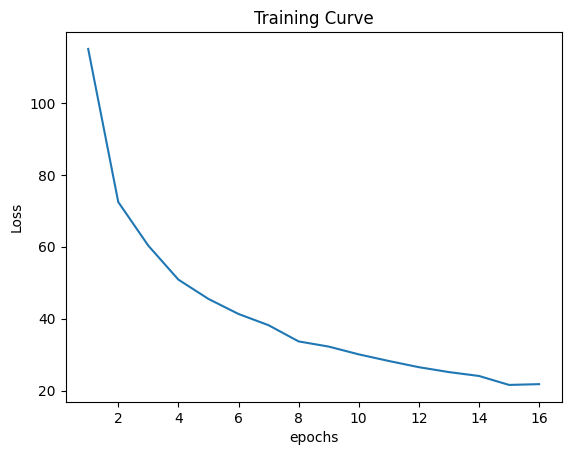

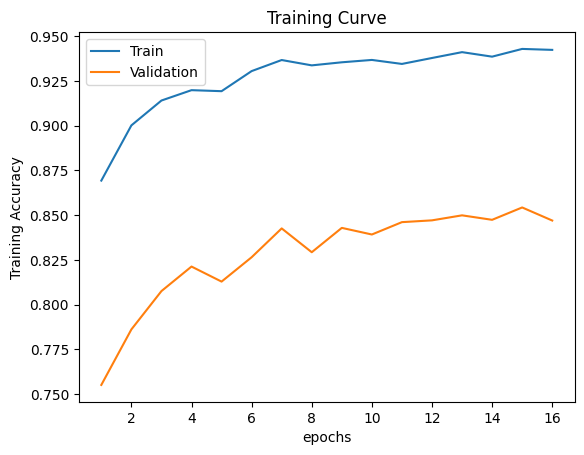

Final Training Accuracy: 0.9423
Final Validation Accuracy: 0.847
rate: 0.01
Epoch 1/16, Training loss(ave. loss per minibatch): 0.76,Time: 1.67713s
Epoch 2/16, Training loss(ave. loss per minibatch): 0.47,Time: 3.2985s
Epoch 3/16, Training loss(ave. loss per minibatch): 0.39,Time: 4.9176s
Epoch 4/16, Training loss(ave. loss per minibatch): 0.33,Time: 6.90135s
Epoch 5/16, Training loss(ave. loss per minibatch): 0.31,Time: 8.46841s
Epoch 6/16, Training loss(ave. loss per minibatch): 0.29,Time: 10.03475s
Epoch 7/16, Training loss(ave. loss per minibatch): 0.26,Time: 11.65667s
Epoch 8/16, Training loss(ave. loss per minibatch): 0.24,Time: 13.27711s
Epoch 9/16, Training loss(ave. loss per minibatch): 0.22,Time: 14.93354s
Epoch 10/16, Training loss(ave. loss per minibatch): 0.23,Time: 16.66173s
Epoch 11/16, Training loss(ave. loss per minibatch): 0.21,Time: 18.51099s
Epoch 12/16, Training loss(ave. loss per minibatch): 0.2,Time: 19.96889s
Epoch 13/16, Training loss(ave. loss per minibatch): 

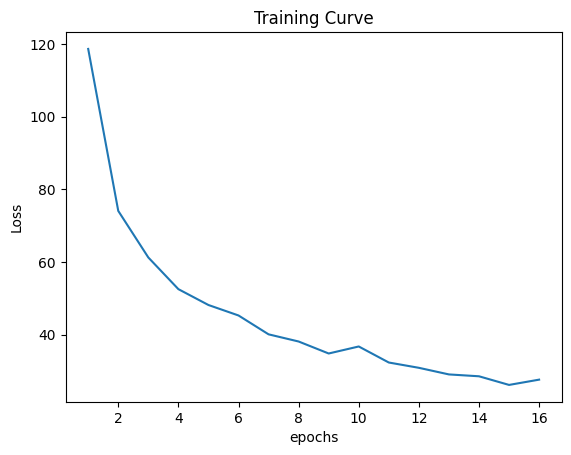

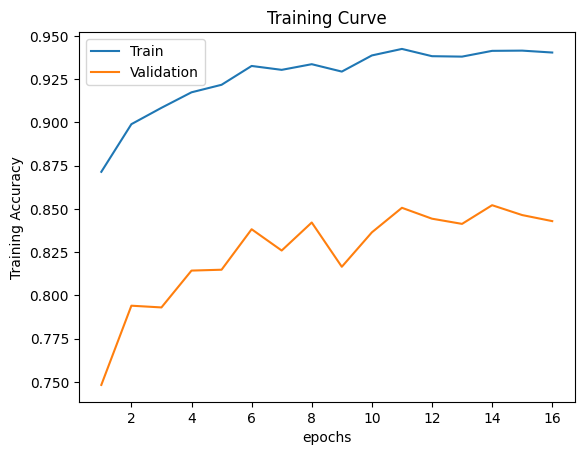

Final Training Accuracy: 0.9403666666666667
Final Validation Accuracy: 0.8429
rate: 0.05
Epoch 1/16, Training loss(ave. loss per minibatch): 0.89,Time: 1.69328s
Epoch 2/16, Training loss(ave. loss per minibatch): 0.6,Time: 3.53186s
Epoch 3/16, Training loss(ave. loss per minibatch): 0.53,Time: 5.12226s
Epoch 4/16, Training loss(ave. loss per minibatch): 0.47,Time: 6.61786s
Epoch 5/16, Training loss(ave. loss per minibatch): 0.44,Time: 8.16796s
Epoch 6/16, Training loss(ave. loss per minibatch): 0.42,Time: 9.70356s
Epoch 7/16, Training loss(ave. loss per minibatch): 0.41,Time: 11.29226s
Epoch 8/16, Training loss(ave. loss per minibatch): 0.39,Time: 12.75509s
Epoch 9/16, Training loss(ave. loss per minibatch): 0.35,Time: 14.66076s
Epoch 10/16, Training loss(ave. loss per minibatch): 0.39,Time: 16.17596s
Epoch 11/16, Training loss(ave. loss per minibatch): 0.35,Time: 17.75617s
Epoch 12/16, Training loss(ave. loss per minibatch): 0.35,Time: 19.3305s
Epoch 13/16, Training loss(ave. loss per

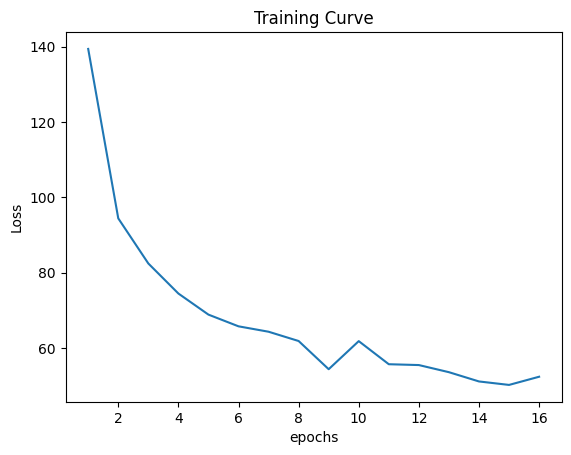

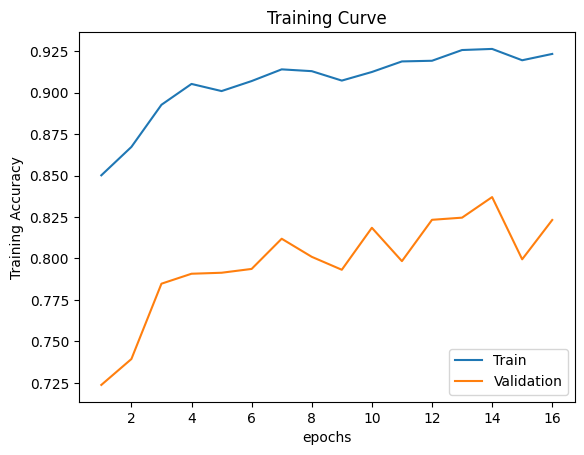

Final Training Accuracy: 0.9232666666666667
Final Validation Accuracy: 0.8232
rate: 0.1
Epoch 1/16, Training loss(ave. loss per minibatch): 1.09,Time: 1.61431s
Epoch 2/16, Training loss(ave. loss per minibatch): 0.71,Time: 3.16354s
Epoch 3/16, Training loss(ave. loss per minibatch): 0.63,Time: 4.75203s
Epoch 4/16, Training loss(ave. loss per minibatch): 0.6,Time: 6.36641s
Epoch 5/16, Training loss(ave. loss per minibatch): 0.55,Time: 7.98154s
Epoch 6/16, Training loss(ave. loss per minibatch): 0.54,Time: 9.78255s
Epoch 7/16, Training loss(ave. loss per minibatch): 0.54,Time: 11.4724s
Epoch 8/16, Training loss(ave. loss per minibatch): 0.54,Time: 12.98977s
Epoch 9/16, Training loss(ave. loss per minibatch): 0.53,Time: 14.62237s
Epoch 10/16, Training loss(ave. loss per minibatch): 0.51,Time: 16.20102s
Epoch 11/16, Training loss(ave. loss per minibatch): 0.48,Time: 17.74844s
Epoch 12/16, Training loss(ave. loss per minibatch): 0.48,Time: 19.34078s
Epoch 13/16, Training loss(ave. loss per 

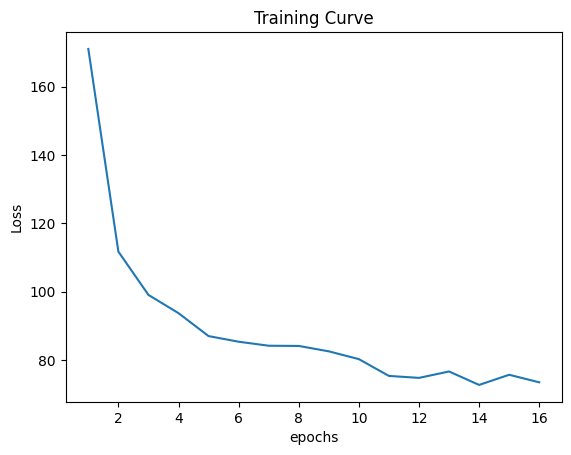

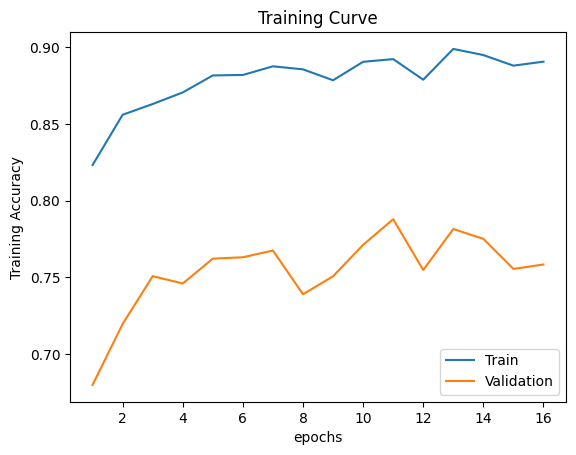

Final Training Accuracy: 0.8905833333333333
Final Validation Accuracy: 0.7584


In [57]:
rate_optns = [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]   # best validation accuracy at 0.001
reset_mod_params(model_both)

for rate in rate_optns:
  print('rate: ' + str(rate))
  train(model_both, mnist_train[:10000], num_epochs=16, lr_choice=rate)
  reset_mod_params(model_both)

Epoch 1/50, Training loss(ave. loss per minibatch): 0.51,Time: 5.05174s
Epoch 2/50, Training loss(ave. loss per minibatch): 0.32,Time: 10.61432s
Epoch 3/50, Training loss(ave. loss per minibatch): 0.27,Time: 15.41671s
Epoch 4/50, Training loss(ave. loss per minibatch): 0.24,Time: 20.69321s
Epoch 5/50, Training loss(ave. loss per minibatch): 0.22,Time: 25.56109s
Epoch 6/50, Training loss(ave. loss per minibatch): 0.2,Time: 30.88026s
Epoch 7/50, Training loss(ave. loss per minibatch): 0.19,Time: 35.70874s
Epoch 8/50, Training loss(ave. loss per minibatch): 0.17,Time: 41.00606s
Epoch 9/50, Training loss(ave. loss per minibatch): 0.17,Time: 46.25s
Epoch 10/50, Training loss(ave. loss per minibatch): 0.16,Time: 51.2508s
Epoch 11/50, Training loss(ave. loss per minibatch): 0.16,Time: 56.33655s
Epoch 12/50, Training loss(ave. loss per minibatch): 0.15,Time: 61.24722s
Epoch 13/50, Training loss(ave. loss per minibatch): 0.14,Time: 66.39908s
Epoch 14/50, Training loss(ave. loss per minibatch): 

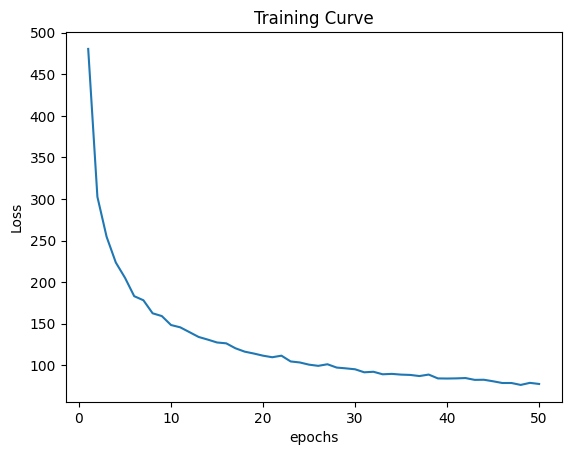

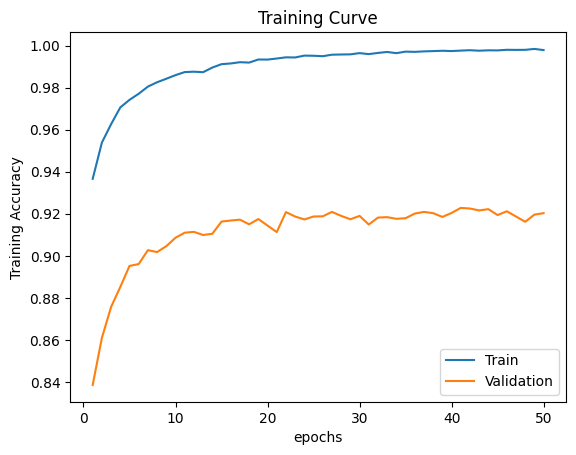

Final Training Accuracy: 0.9978666666666667
Final Validation Accuracy: 0.9203


In [58]:
train(model_both, mnist_train, num_epochs=50, lr_choice=0.001)   # best validation accuracy at either around 28 or around 38 epochs but very little improvement past 28
reset_mod_params(model_both)

gradient clipping value

max gradient: 0.1
Epoch 1/16, Training loss(ave. loss per minibatch): 0.76,Time: 1.51714s
Epoch 2/16, Training loss(ave. loss per minibatch): 0.51,Time: 3.1277s
Epoch 3/16, Training loss(ave. loss per minibatch): 0.42,Time: 4.68513s
Epoch 4/16, Training loss(ave. loss per minibatch): 0.37,Time: 6.33039s
Epoch 5/16, Training loss(ave. loss per minibatch): 0.33,Time: 7.98188s
Epoch 6/16, Training loss(ave. loss per minibatch): 0.29,Time: 9.87107s
Epoch 7/16, Training loss(ave. loss per minibatch): 0.26,Time: 11.48893s
Epoch 8/16, Training loss(ave. loss per minibatch): 0.25,Time: 13.0072s
Epoch 9/16, Training loss(ave. loss per minibatch): 0.22,Time: 14.56935s
Epoch 10/16, Training loss(ave. loss per minibatch): 0.22,Time: 16.05444s
Epoch 11/16, Training loss(ave. loss per minibatch): 0.21,Time: 17.58927s
Epoch 12/16, Training loss(ave. loss per minibatch): 0.2,Time: 19.17433s
Epoch 13/16, Training loss(ave. loss per minibatch): 0.2,Time: 21.11117s
Epoch 14/16, Training loss(ave. loss pe

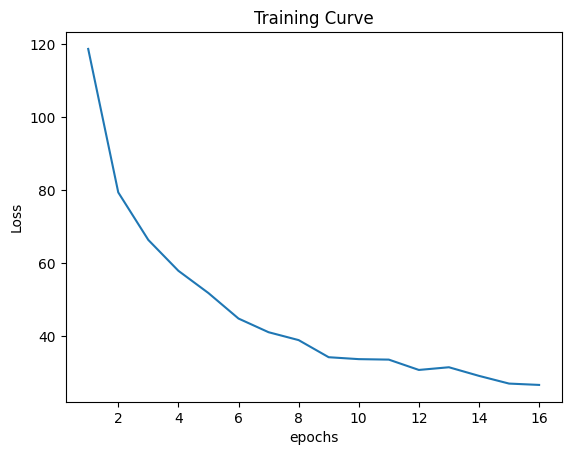

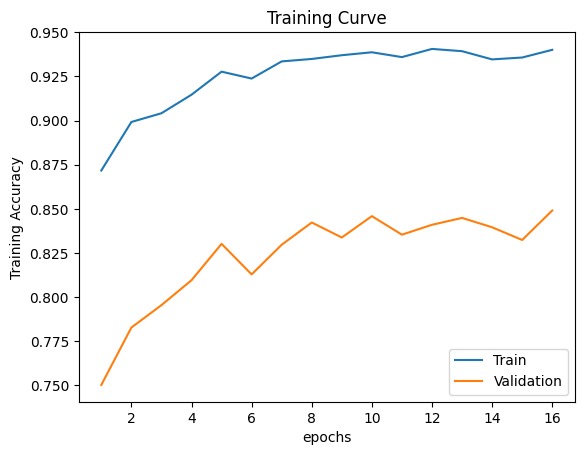

Final Training Accuracy: 0.9401
Final Validation Accuracy: 0.8491
max gradient: 0.5
Epoch 1/16, Training loss(ave. loss per minibatch): 0.76,Time: 1.54343s
Epoch 2/16, Training loss(ave. loss per minibatch): 0.51,Time: 3.13835s
Epoch 3/16, Training loss(ave. loss per minibatch): 0.4,Time: 4.78124s
Epoch 4/16, Training loss(ave. loss per minibatch): 0.35,Time: 6.69457s
Epoch 5/16, Training loss(ave. loss per minibatch): 0.31,Time: 8.32305s
Epoch 6/16, Training loss(ave. loss per minibatch): 0.28,Time: 9.88692s
Epoch 7/16, Training loss(ave. loss per minibatch): 0.26,Time: 11.48879s
Epoch 8/16, Training loss(ave. loss per minibatch): 0.25,Time: 13.07793s
Epoch 9/16, Training loss(ave. loss per minibatch): 0.21,Time: 14.66308s
Epoch 10/16, Training loss(ave. loss per minibatch): 0.21,Time: 16.3472s
Epoch 11/16, Training loss(ave. loss per minibatch): 0.2,Time: 18.1625s
Epoch 12/16, Training loss(ave. loss per minibatch): 0.2,Time: 19.7567s
Epoch 13/16, Training loss(ave. loss per minibatc

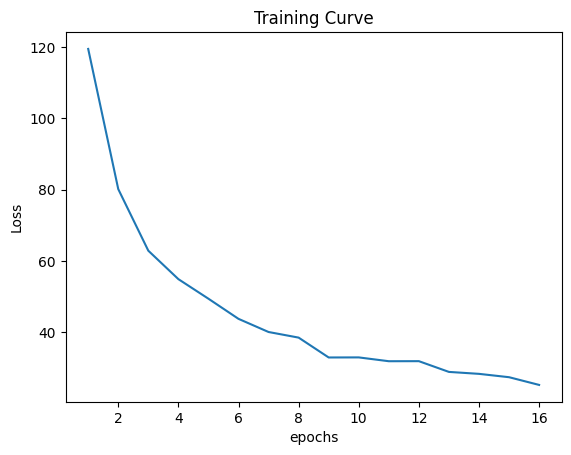

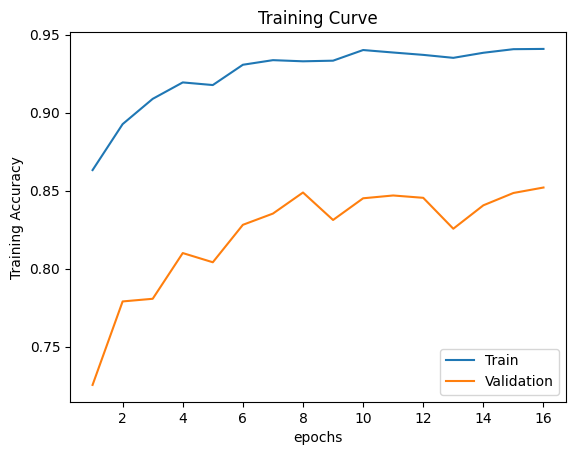

Final Training Accuracy: 0.9408166666666666
Final Validation Accuracy: 0.852
max gradient: 1.0
Epoch 1/16, Training loss(ave. loss per minibatch): 0.77,Time: 1.85045s
Epoch 2/16, Training loss(ave. loss per minibatch): 0.49,Time: 3.48359s
Epoch 3/16, Training loss(ave. loss per minibatch): 0.39,Time: 5.105s
Epoch 4/16, Training loss(ave. loss per minibatch): 0.34,Time: 6.663s
Epoch 5/16, Training loss(ave. loss per minibatch): 0.31,Time: 8.18477s
Epoch 6/16, Training loss(ave. loss per minibatch): 0.29,Time: 9.76919s
Epoch 7/16, Training loss(ave. loss per minibatch): 0.26,Time: 11.38918s
Epoch 8/16, Training loss(ave. loss per minibatch): 0.25,Time: 13.37002s
Epoch 9/16, Training loss(ave. loss per minibatch): 0.22,Time: 15.01954s
Epoch 10/16, Training loss(ave. loss per minibatch): 0.22,Time: 16.71099s
Epoch 11/16, Training loss(ave. loss per minibatch): 0.21,Time: 18.29668s
Epoch 12/16, Training loss(ave. loss per minibatch): 0.19,Time: 19.83068s
Epoch 13/16, Training loss(ave. loss

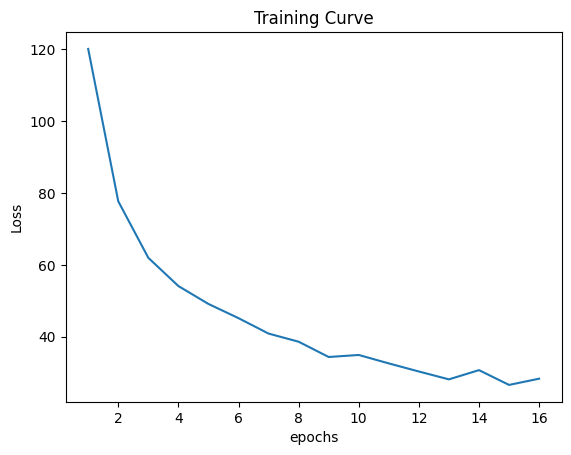

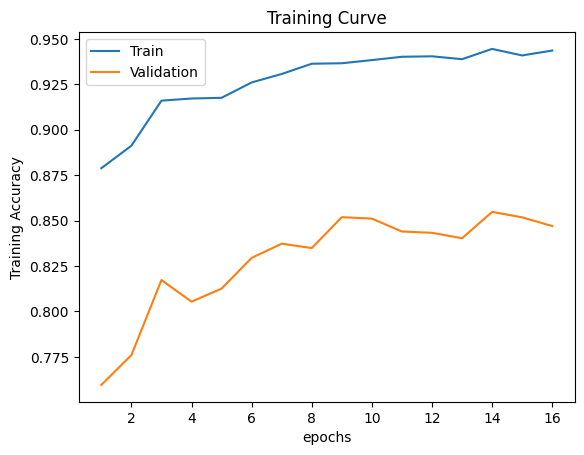

Final Training Accuracy: 0.9435666666666667
Final Validation Accuracy: 0.847
max gradient: 1.5
Epoch 1/16, Training loss(ave. loss per minibatch): 0.73,Time: 1.51986s
Epoch 2/16, Training loss(ave. loss per minibatch): 0.49,Time: 3.08534s
Epoch 3/16, Training loss(ave. loss per minibatch): 0.39,Time: 4.62913s
Epoch 4/16, Training loss(ave. loss per minibatch): 0.34,Time: 6.22385s
Epoch 5/16, Training loss(ave. loss per minibatch): 0.33,Time: 7.80992s
Epoch 6/16, Training loss(ave. loss per minibatch): 0.29,Time: 9.85608s
Epoch 7/16, Training loss(ave. loss per minibatch): 0.26,Time: 11.47261s
Epoch 8/16, Training loss(ave. loss per minibatch): 0.25,Time: 12.94911s
Epoch 9/16, Training loss(ave. loss per minibatch): 0.22,Time: 14.51927s
Epoch 10/16, Training loss(ave. loss per minibatch): 0.22,Time: 16.04395s
Epoch 11/16, Training loss(ave. loss per minibatch): 0.2,Time: 17.58616s
Epoch 12/16, Training loss(ave. loss per minibatch): 0.2,Time: 19.1854s
Epoch 13/16, Training loss(ave. los

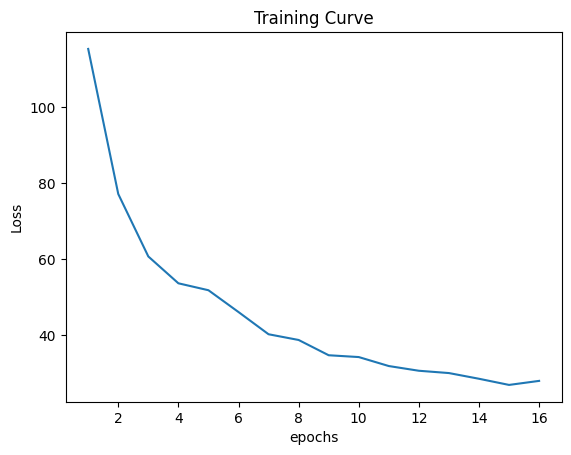

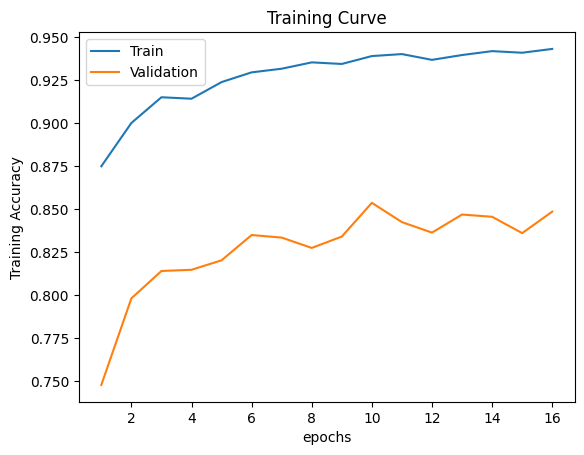

Final Training Accuracy: 0.9432333333333334
Final Validation Accuracy: 0.8487
max gradient: 2.0
Epoch 1/16, Training loss(ave. loss per minibatch): 0.73,Time: 1.56652s
Epoch 2/16, Training loss(ave. loss per minibatch): 0.49,Time: 3.10487s
Epoch 3/16, Training loss(ave. loss per minibatch): 0.41,Time: 4.6219s
Epoch 4/16, Training loss(ave. loss per minibatch): 0.36,Time: 6.51437s
Epoch 5/16, Training loss(ave. loss per minibatch): 0.32,Time: 8.0377s
Epoch 6/16, Training loss(ave. loss per minibatch): 0.28,Time: 9.58257s
Epoch 7/16, Training loss(ave. loss per minibatch): 0.28,Time: 11.14143s
Epoch 8/16, Training loss(ave. loss per minibatch): 0.24,Time: 12.71264s
Epoch 9/16, Training loss(ave. loss per minibatch): 0.24,Time: 14.30883s
Epoch 10/16, Training loss(ave. loss per minibatch): 0.23,Time: 15.91956s
Epoch 11/16, Training loss(ave. loss per minibatch): 0.22,Time: 17.94703s
Epoch 12/16, Training loss(ave. loss per minibatch): 0.2,Time: 19.56351s
Epoch 13/16, Training loss(ave. lo

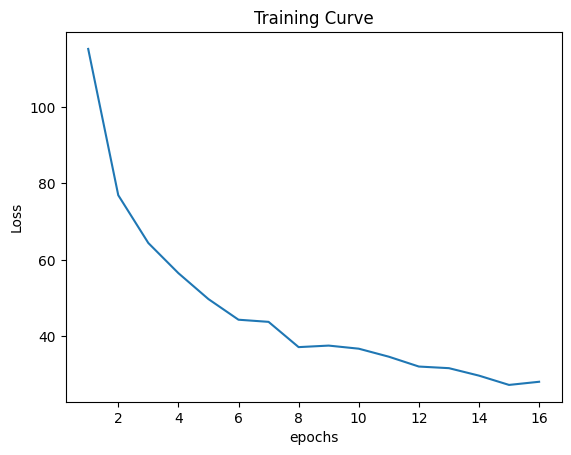

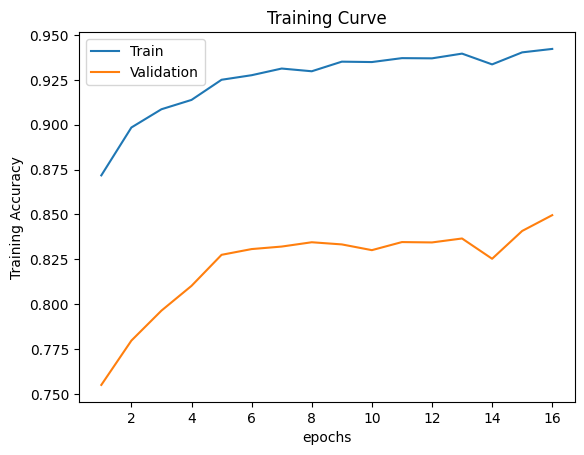

Final Training Accuracy: 0.9422333333333334
Final Validation Accuracy: 0.8496
max gradient: 2.5
Epoch 1/16, Training loss(ave. loss per minibatch): 0.76,Time: 1.56714s
Epoch 2/16, Training loss(ave. loss per minibatch): 0.49,Time: 3.41903s
Epoch 3/16, Training loss(ave. loss per minibatch): 0.39,Time: 4.98611s
Epoch 4/16, Training loss(ave. loss per minibatch): 0.35,Time: 6.51212s
Epoch 5/16, Training loss(ave. loss per minibatch): 0.31,Time: 8.07612s
Epoch 6/16, Training loss(ave. loss per minibatch): 0.29,Time: 9.58091s
Epoch 7/16, Training loss(ave. loss per minibatch): 0.27,Time: 11.07418s
Epoch 8/16, Training loss(ave. loss per minibatch): 0.25,Time: 12.67613s
Epoch 9/16, Training loss(ave. loss per minibatch): 0.24,Time: 14.60615s
Epoch 10/16, Training loss(ave. loss per minibatch): 0.21,Time: 16.14661s
Epoch 11/16, Training loss(ave. loss per minibatch): 0.2,Time: 17.72427s
Epoch 12/16, Training loss(ave. loss per minibatch): 0.19,Time: 19.26265s
Epoch 13/16, Training loss(ave. 

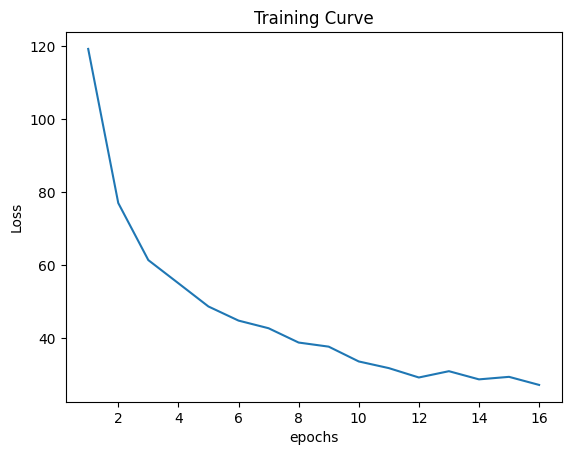

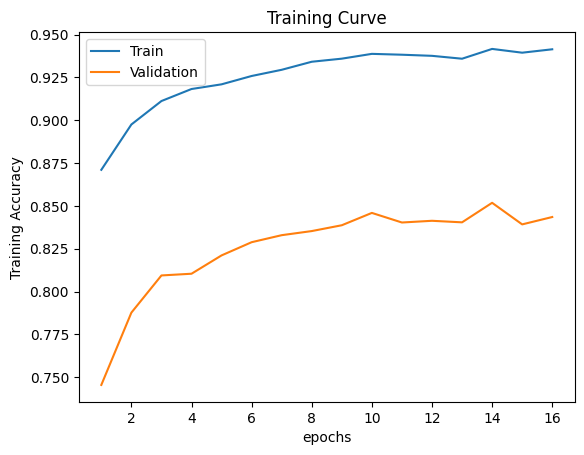

Final Training Accuracy: 0.9414
Final Validation Accuracy: 0.8435
max gradient: 3.0
Epoch 1/16, Training loss(ave. loss per minibatch): 0.76,Time: 1.73208s
Epoch 2/16, Training loss(ave. loss per minibatch): 0.49,Time: 3.23751s
Epoch 3/16, Training loss(ave. loss per minibatch): 0.41,Time: 4.80105s
Epoch 4/16, Training loss(ave. loss per minibatch): 0.34,Time: 6.34634s
Epoch 5/16, Training loss(ave. loss per minibatch): 0.31,Time: 7.92022s
Epoch 6/16, Training loss(ave. loss per minibatch): 0.29,Time: 9.59387s
Epoch 7/16, Training loss(ave. loss per minibatch): 0.28,Time: 11.39131s
Epoch 8/16, Training loss(ave. loss per minibatch): 0.25,Time: 12.93613s
Epoch 9/16, Training loss(ave. loss per minibatch): 0.24,Time: 14.51078s
Epoch 10/16, Training loss(ave. loss per minibatch): 0.21,Time: 16.08815s
Epoch 11/16, Training loss(ave. loss per minibatch): 0.2,Time: 17.62978s
Epoch 12/16, Training loss(ave. loss per minibatch): 0.23,Time: 19.21402s
Epoch 13/16, Training loss(ave. loss per min

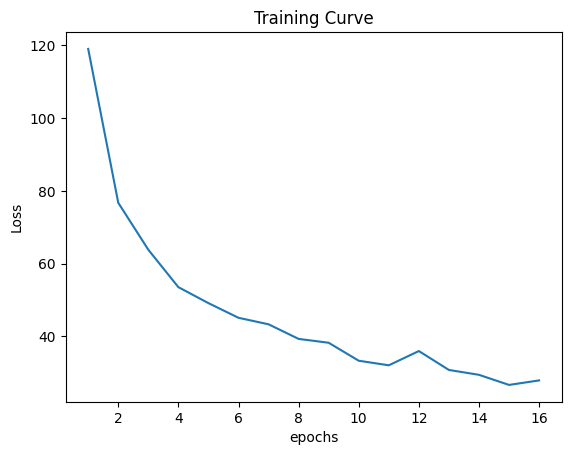

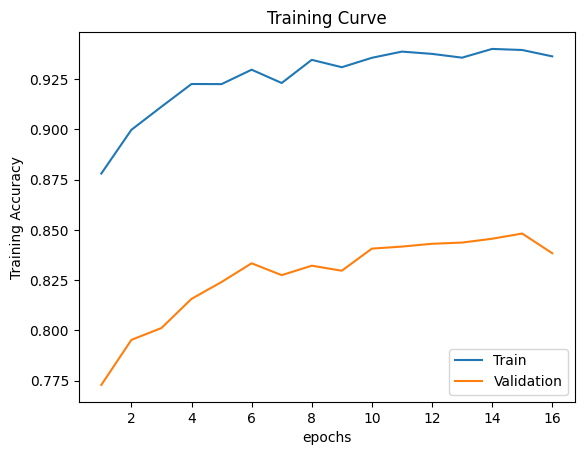

Final Training Accuracy: 0.9363166666666667
Final Validation Accuracy: 0.8384


In [59]:
clips = [0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]   # 1.5 gives the best validation accuracy
reset_mod_params(model_both)

for grad in clips:
  print('max gradient: ' + str(grad))
  train(model_both, mnist_train[:10000], num_epochs=16, grad_clip=grad)
  reset_mod_params(model_both)

### Training on the full training dataset

Epoch 1/28, Training loss(ave. loss per minibatch): 0.33,Time: 4.3259s
Epoch 2/28, Training loss(ave. loss per minibatch): 0.14,Time: 9.05659s
Epoch 3/28, Training loss(ave. loss per minibatch): 0.09,Time: 13.53229s
Epoch 4/28, Training loss(ave. loss per minibatch): 0.06,Time: 18.11042s
Epoch 5/28, Training loss(ave. loss per minibatch): 0.04,Time: 22.56941s
Epoch 6/28, Training loss(ave. loss per minibatch): 0.03,Time: 26.94999s
Epoch 7/28, Training loss(ave. loss per minibatch): 0.03,Time: 31.64095s
Epoch 8/28, Training loss(ave. loss per minibatch): 0.02,Time: 36.17992s
Epoch 9/28, Training loss(ave. loss per minibatch): 0.02,Time: 40.59778s
Epoch 10/28, Training loss(ave. loss per minibatch): 0.02,Time: 45.12787s
Epoch 11/28, Training loss(ave. loss per minibatch): 0.02,Time: 49.38397s
Epoch 12/28, Training loss(ave. loss per minibatch): 0.01,Time: 54.00861s
Epoch 13/28, Training loss(ave. loss per minibatch): 0.02,Time: 58.38828s
Epoch 14/28, Training loss(ave. loss per minibatch

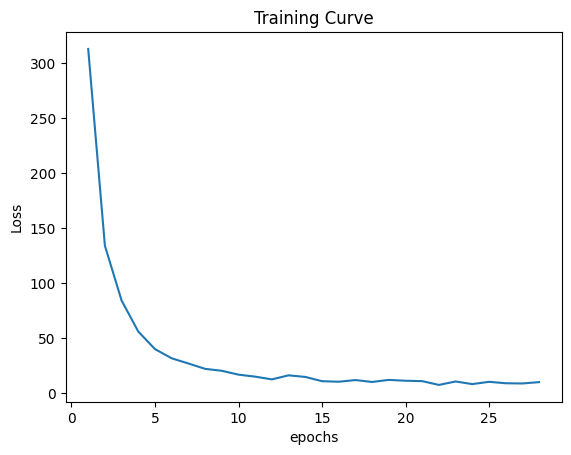

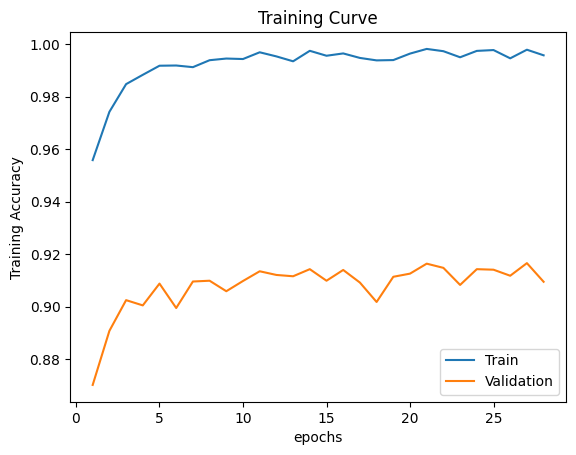

Final Training Accuracy: 0.9957833333333334
Final Validation Accuracy: 0.9095


In [60]:
train(model, mnist_train, lr_choice=0.001, num_epochs=28, grad_clip=1.5)

Epoch 1/28, Training loss(ave. loss per minibatch): 0.51,Time: 4.79538s
Epoch 2/28, Training loss(ave. loss per minibatch): 0.31,Time: 9.07417s
Epoch 3/28, Training loss(ave. loss per minibatch): 0.26,Time: 13.76135s
Epoch 4/28, Training loss(ave. loss per minibatch): 0.23,Time: 17.94626s
Epoch 5/28, Training loss(ave. loss per minibatch): 0.21,Time: 22.1849s
Epoch 6/28, Training loss(ave. loss per minibatch): 0.19,Time: 26.85396s
Epoch 7/28, Training loss(ave. loss per minibatch): 0.18,Time: 31.14439s
Epoch 8/28, Training loss(ave. loss per minibatch): 0.17,Time: 35.76219s
Epoch 9/28, Training loss(ave. loss per minibatch): 0.16,Time: 40.15732s
Epoch 10/28, Training loss(ave. loss per minibatch): 0.16,Time: 44.45984s
Epoch 11/28, Training loss(ave. loss per minibatch): 0.15,Time: 49.10272s
Epoch 12/28, Training loss(ave. loss per minibatch): 0.15,Time: 53.53547s
Epoch 13/28, Training loss(ave. loss per minibatch): 0.14,Time: 57.93407s
Epoch 14/28, Training loss(ave. loss per minibatch

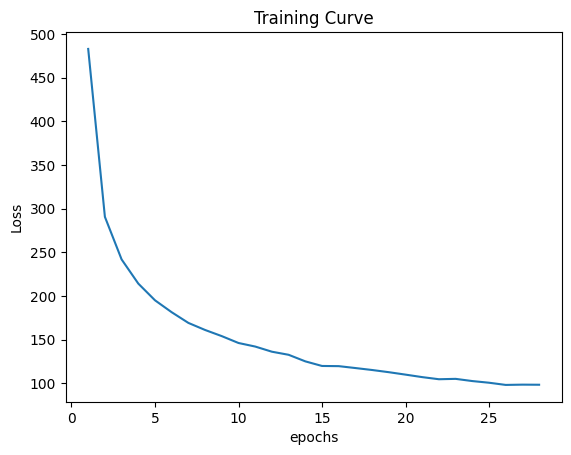

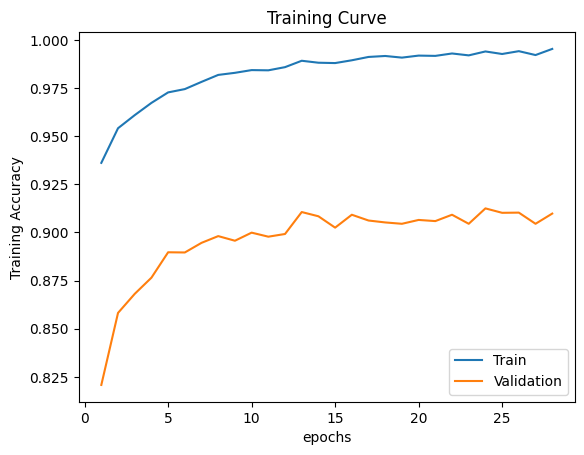

Final Training Accuracy: 0.9953333333333333
Final Validation Accuracy: 0.9098


In [61]:
train(model_drop, mnist_train, lr_choice=0.001, num_epochs=28, grad_clip=1.5)

Epoch 1/28, Training loss(ave. loss per minibatch): 0.32,Time: 5.28235s
Epoch 2/28, Training loss(ave. loss per minibatch): 0.15,Time: 10.08281s
Epoch 3/28, Training loss(ave. loss per minibatch): 0.1,Time: 15.18505s
Epoch 4/28, Training loss(ave. loss per minibatch): 0.07,Time: 20.03201s
Epoch 5/28, Training loss(ave. loss per minibatch): 0.06,Time: 24.99979s
Epoch 6/28, Training loss(ave. loss per minibatch): 0.05,Time: 29.55368s
Epoch 7/28, Training loss(ave. loss per minibatch): 0.04,Time: 34.22241s
Epoch 8/28, Training loss(ave. loss per minibatch): 0.03,Time: 39.43259s
Epoch 9/28, Training loss(ave. loss per minibatch): 0.03,Time: 44.25601s
Epoch 10/28, Training loss(ave. loss per minibatch): 0.03,Time: 49.51922s
Epoch 11/28, Training loss(ave. loss per minibatch): 0.03,Time: 54.3178s
Epoch 12/28, Training loss(ave. loss per minibatch): 0.02,Time: 59.40468s
Epoch 13/28, Training loss(ave. loss per minibatch): 0.02,Time: 64.20718s
Epoch 14/28, Training loss(ave. loss per minibatch

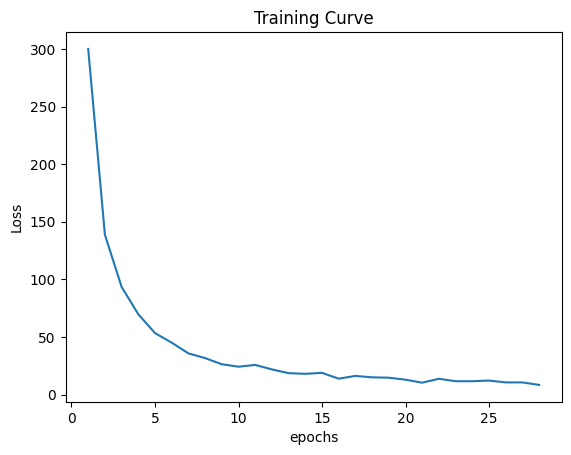

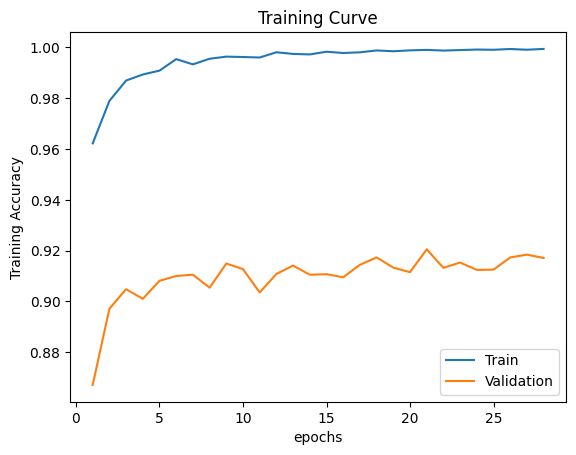

Final Training Accuracy: 0.9994166666666666
Final Validation Accuracy: 0.9171


In [62]:
train(model_bn, mnist_train, lr_choice=0.001, num_epochs=28, grad_clip=1.5)

Epoch 1/28, Training loss(ave. loss per minibatch): 0.51,Time: 5.21869s
Epoch 2/28, Training loss(ave. loss per minibatch): 0.32,Time: 14.07076s
Epoch 3/28, Training loss(ave. loss per minibatch): 0.27,Time: 18.93144s
Epoch 4/28, Training loss(ave. loss per minibatch): 0.24,Time: 24.56495s
Epoch 5/28, Training loss(ave. loss per minibatch): 0.22,Time: 29.6368s
Epoch 6/28, Training loss(ave. loss per minibatch): 0.21,Time: 35.04424s
Epoch 7/28, Training loss(ave. loss per minibatch): 0.19,Time: 40.46594s
Epoch 8/28, Training loss(ave. loss per minibatch): 0.18,Time: 46.15835s
Epoch 9/28, Training loss(ave. loss per minibatch): 0.17,Time: 51.05936s
Epoch 10/28, Training loss(ave. loss per minibatch): 0.16,Time: 56.41376s
Epoch 11/28, Training loss(ave. loss per minibatch): 0.16,Time: 61.32642s
Epoch 12/28, Training loss(ave. loss per minibatch): 0.15,Time: 66.5751s
Epoch 13/28, Training loss(ave. loss per minibatch): 0.15,Time: 71.38894s
Epoch 14/28, Training loss(ave. loss per minibatch

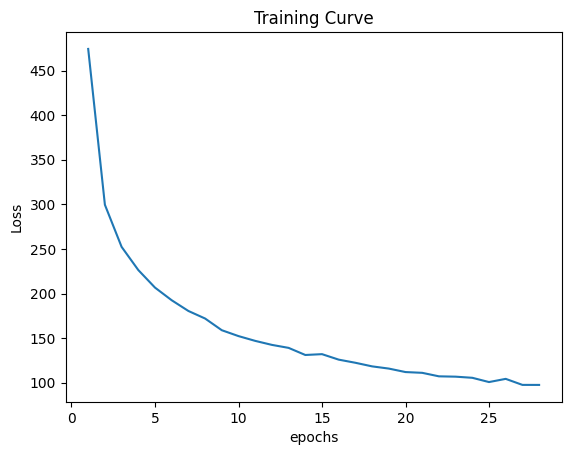

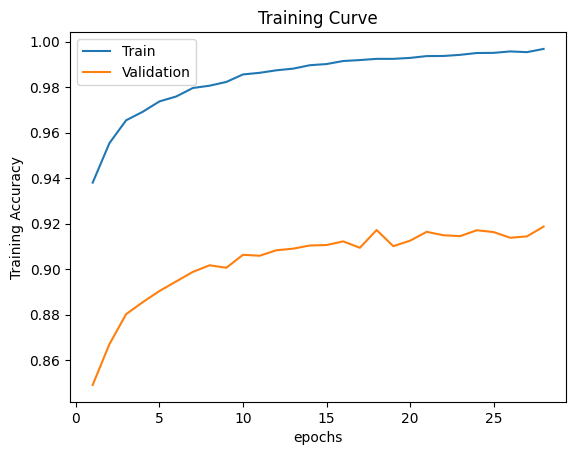

Final Training Accuracy: 0.9968166666666667
Final Validation Accuracy: 0.9187


In [63]:
train(model_both, mnist_train, lr_choice=0.001, num_epochs=28, grad_clip=1.5)

Epoch 1/28, Training loss(ave. loss per minibatch): 0.66,Time: 13.09466s
Epoch 2/28, Training loss(ave. loss per minibatch): 0.4,Time: 26.01937s
Epoch 3/28, Training loss(ave. loss per minibatch): 0.33,Time: 39.0435s
Epoch 4/28, Training loss(ave. loss per minibatch): 0.29,Time: 52.42324s
Epoch 5/28, Training loss(ave. loss per minibatch): 0.26,Time: 65.29201s
Epoch 6/28, Training loss(ave. loss per minibatch): 0.24,Time: 78.3757s
Epoch 7/28, Training loss(ave. loss per minibatch): 0.22,Time: 91.50453s
Epoch 8/28, Training loss(ave. loss per minibatch): 0.21,Time: 104.61126s
Epoch 9/28, Training loss(ave. loss per minibatch): 0.19,Time: 117.79563s
Epoch 10/28, Training loss(ave. loss per minibatch): 0.19,Time: 131.53391s
Epoch 11/28, Training loss(ave. loss per minibatch): 0.18,Time: 145.01685s
Epoch 12/28, Training loss(ave. loss per minibatch): 0.17,Time: 158.37695s
Epoch 13/28, Training loss(ave. loss per minibatch): 0.16,Time: 171.44346s
Epoch 14/28, Training loss(ave. loss per min

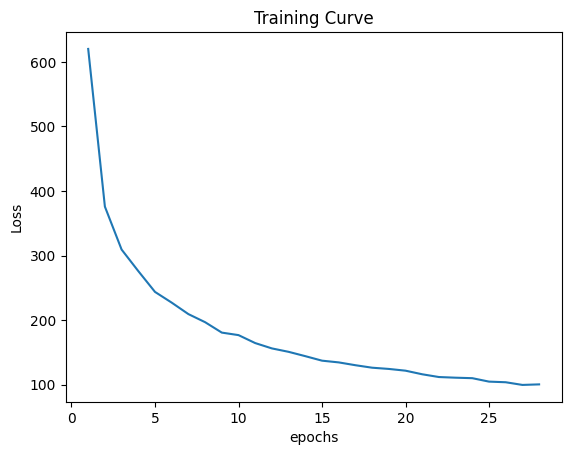

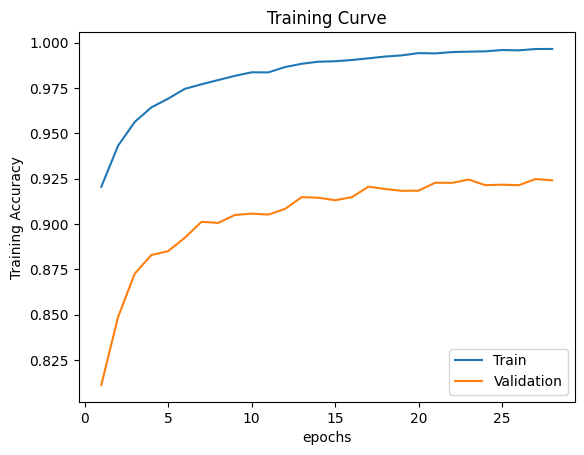

Final Training Accuracy: 0.9966
Final Validation Accuracy: 0.9241


In [64]:
train(model_five_layer, mnist_train, lr_choice=0.001, num_epochs=28, grad_clip=1.5)

model_five_layer has the best validation accuracy but is not substantially better than the 3-layer version (model_both). This is probably because the extra layers are not reveal any new or complex patterns. The five layer model takes almost three times as long to complete the 28 epochs of learning and so while it gives a better result, it is not as efficient (in terms of time spent) as the 3-layer model_both.

Both `nn.Dropout()` and `nn.Batchnorm1d()` were used in an attempt to reduce overfitting but only 'Batchnorm' appeared to improve the validation accuracy. Also, only Batchnorm appeared to reduce overfitting whne both were used alone but using both techniques resulted in a better result than using either of them alone (using *Overfitting ≈ Validation Accuracy / Training Accuracy* to give a metric of a change in overfitting, where a number closer to 1 corresponds to a less overfit model):

| **Model**  | **Overfitting** | **Technique** |
| ---------- | --------------- | ------------- |
|   model    |      0.916      |    Neither    |
| model_drop |      0.912      |    Dropout    |
|  model_bn  |      0.922      |   Batchnorm   |
| model_both |      0.923      |     Both      |

## Investigate the relationship between learning rate (lr) and gradient clipping value (grad_clip)

Base Model

Epoch 1/16, Training loss(ave. loss per minibatch): 0.41,Time: 4.37048s
Epoch 2/16, Training loss(ave. loss per minibatch): 0.26,Time: 8.76634s
Epoch 3/16, Training loss(ave. loss per minibatch): 0.23,Time: 13.37393s
Epoch 4/16, Training loss(ave. loss per minibatch): 0.21,Time: 17.58465s
Epoch 5/16, Training loss(ave. loss per minibatch): 0.19,Time: 22.20242s
Epoch 6/16, Training loss(ave. loss per minibatch): 0.18,Time: 26.50704s
Epoch 7/16, Training loss(ave. loss per minibatch): 0.16,Time: 30.78376s
Epoch 8/16, Training loss(ave. loss per minibatch): 0.15,Time: 35.20364s
Epoch 9/16, Training loss(ave. loss per minibatch): 0.15,Time: 39.37791s
Epoch 10/16, Training loss(ave. loss per minibatch): 0.15,Time: 43.85224s
Epoch 11/16, Training loss(ave. loss per minibatch): 0.14,Time: 48.40322s
Epoch 12/16, Training loss(ave. loss per minibatch): 0.13,Time: 52.6189s
Epoch 13/16, Training loss(ave. loss per minibatch): 0.13,Time: 57.27015s
Epoch 14/16, Training loss(ave. loss per minibatch

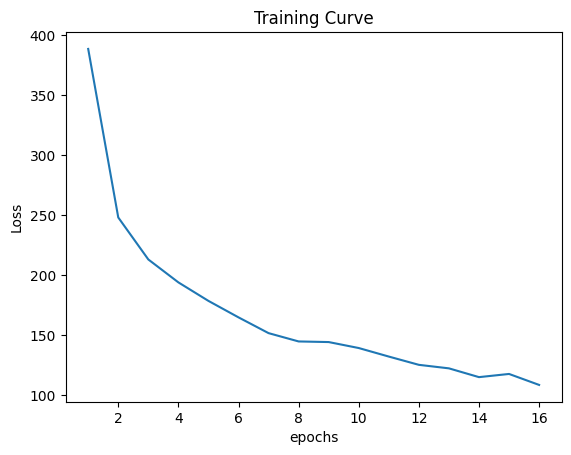

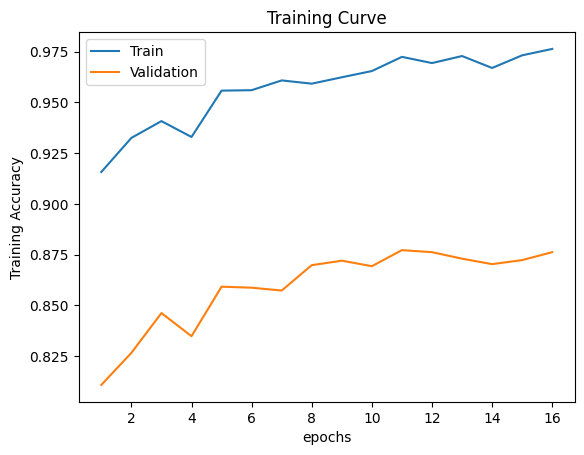

Final Training Accuracy: 0.9763333333333334
Final Validation Accuracy: 0.8762


In [65]:
reset_mod_params(model)
train(model, mnist_train, num_epochs=16)   # lr = 0.01 and grad_clip = 1.0

Increasing grad_clip

Epoch 1/16, Training loss(ave. loss per minibatch): 0.41,Time: 4.31339s
Epoch 2/16, Training loss(ave. loss per minibatch): 0.27,Time: 9.01272s
Epoch 3/16, Training loss(ave. loss per minibatch): 0.23,Time: 13.36686s
Epoch 4/16, Training loss(ave. loss per minibatch): 0.21,Time: 17.67725s
Epoch 5/16, Training loss(ave. loss per minibatch): 0.18,Time: 22.35085s
Epoch 6/16, Training loss(ave. loss per minibatch): 0.17,Time: 26.67606s
Epoch 7/16, Training loss(ave. loss per minibatch): 0.16,Time: 31.19893s
Epoch 8/16, Training loss(ave. loss per minibatch): 0.16,Time: 35.35499s
Epoch 9/16, Training loss(ave. loss per minibatch): 0.15,Time: 39.37674s
Epoch 10/16, Training loss(ave. loss per minibatch): 0.14,Time: 44.06528s
Epoch 11/16, Training loss(ave. loss per minibatch): 0.14,Time: 48.6025s
Epoch 12/16, Training loss(ave. loss per minibatch): 0.14,Time: 53.36939s
Epoch 13/16, Training loss(ave. loss per minibatch): 0.13,Time: 57.76504s
Epoch 14/16, Training loss(ave. loss per minibatch

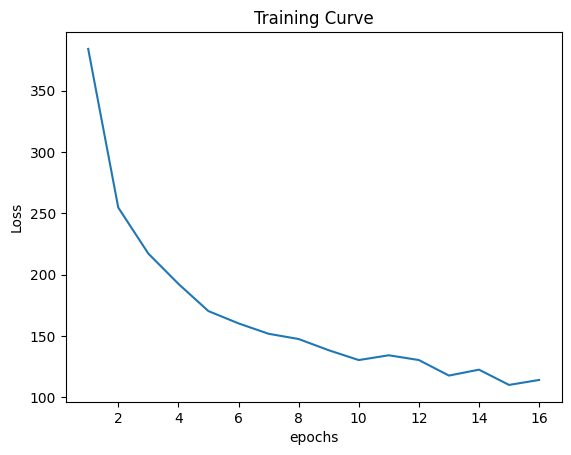

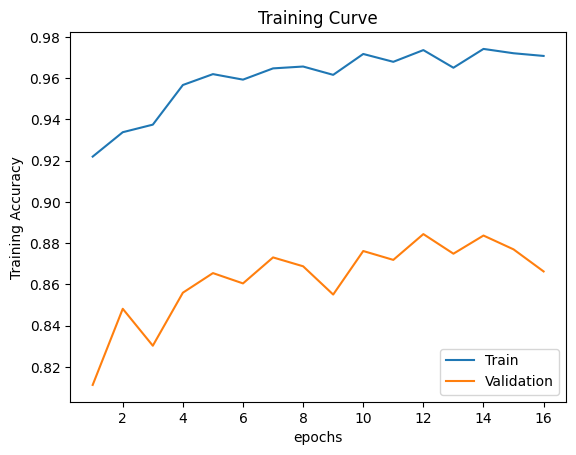

Final Training Accuracy: 0.97075
Final Validation Accuracy: 0.8663


In [66]:
reset_mod_params(model)
train(model, mnist_train, num_epochs=16, grad_clip=10)   # lr = 0.01 (kept constant)

Lower validation accuracy, changing learning rate

Epoch 1/16, Training loss(ave. loss per minibatch): 0.35,Time: 4.99901s
Epoch 2/16, Training loss(ave. loss per minibatch): 0.18,Time: 9.20827s
Epoch 3/16, Training loss(ave. loss per minibatch): 0.14,Time: 13.43991s
Epoch 4/16, Training loss(ave. loss per minibatch): 0.13,Time: 18.08835s
Epoch 5/16, Training loss(ave. loss per minibatch): 0.12,Time: 22.27006s
Epoch 6/16, Training loss(ave. loss per minibatch): 0.1,Time: 26.52986s
Epoch 7/16, Training loss(ave. loss per minibatch): 0.09,Time: 31.21536s
Epoch 8/16, Training loss(ave. loss per minibatch): 0.09,Time: 35.52578s
Epoch 9/16, Training loss(ave. loss per minibatch): 0.09,Time: 40.32454s
Epoch 10/16, Training loss(ave. loss per minibatch): 0.07,Time: 44.72163s
Epoch 11/16, Training loss(ave. loss per minibatch): 0.08,Time: 48.90136s
Epoch 12/16, Training loss(ave. loss per minibatch): 0.08,Time: 53.6368s
Epoch 13/16, Training loss(ave. loss per minibatch): 0.08,Time: 57.8955s
Epoch 14/16, Training loss(ave. loss per minibatch):

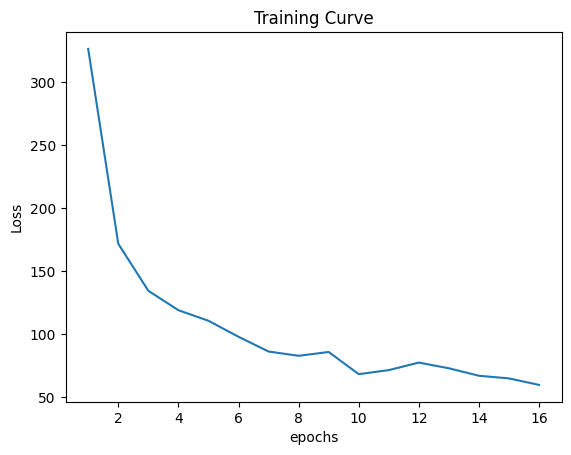

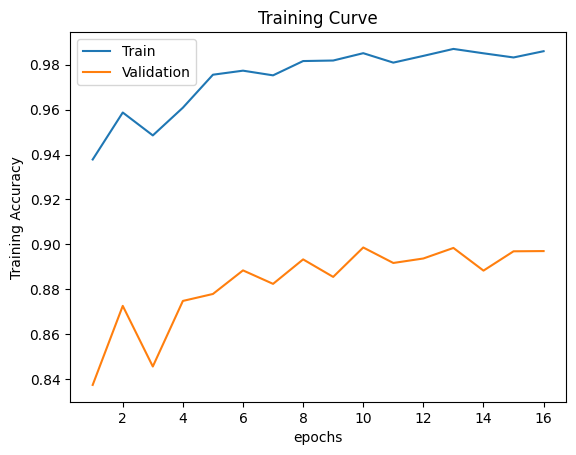

Final Training Accuracy: 0.986
Final Validation Accuracy: 0.897


In [67]:
# lowering learning rate
reset_mod_params(model)
train(model, mnist_train, num_epochs=16, lr_choice=0.005, grad_clip=10)

Epoch 1/16, Training loss(ave. loss per minibatch): 0.56,Time: 4.72512s
Epoch 2/16, Training loss(ave. loss per minibatch): 0.43,Time: 9.10252s
Epoch 3/16, Training loss(ave. loss per minibatch): 0.38,Time: 13.6706s
Epoch 4/16, Training loss(ave. loss per minibatch): 0.37,Time: 17.92255s
Epoch 5/16, Training loss(ave. loss per minibatch): 0.36,Time: 22.05047s
Epoch 6/16, Training loss(ave. loss per minibatch): 0.34,Time: 26.69377s
Epoch 7/16, Training loss(ave. loss per minibatch): 0.35,Time: 30.87228s
Epoch 8/16, Training loss(ave. loss per minibatch): 0.34,Time: 35.59711s
Epoch 9/16, Training loss(ave. loss per minibatch): 0.35,Time: 39.97567s
Epoch 10/16, Training loss(ave. loss per minibatch): 0.32,Time: 44.17794s
Epoch 11/16, Training loss(ave. loss per minibatch): 0.33,Time: 48.75774s
Epoch 12/16, Training loss(ave. loss per minibatch): 0.33,Time: 53.04607s
Epoch 13/16, Training loss(ave. loss per minibatch): 0.32,Time: 57.26203s
Epoch 14/16, Training loss(ave. loss per minibatch

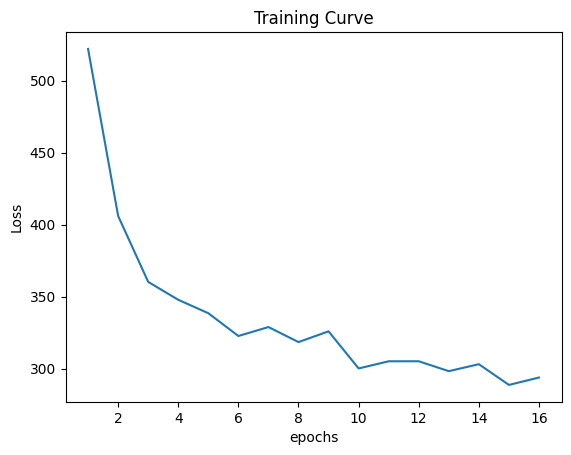

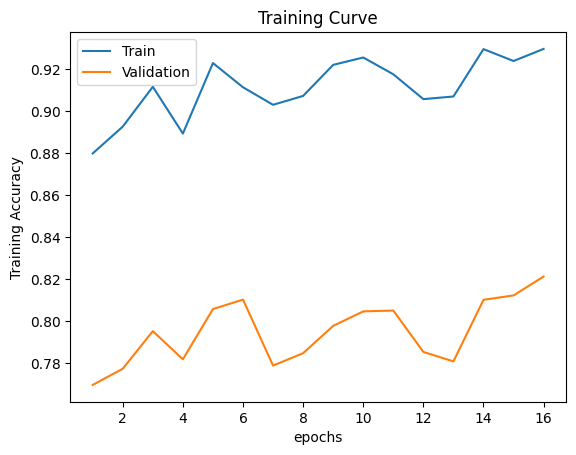

Final Training Accuracy: 0.9297166666666666
Final Validation Accuracy: 0.8214


In [68]:
# increasing learning rate
reset_mod_params(model)
train(model, mnist_train, num_epochs=16, lr_choice=0.02, grad_clip=10)

Both learning rate `lr_choice` and gradient clip value `grad_clip` affect how much a model's weights are updated in training. Gradient clipping helps avoid the gradient changing the weights too drastically and the learning rate decides the size of the change in the direction of the gradient.

Here, it appears that an increase in `grad_clip` can result in an increase in voaltility in training, sometimes eventually resulting in large jumps and a decrease in accuracy.

Inrceasing the learning rate will accentuate the volatility and potentially worse accuracy caused by an increase in `grad_clip`, whereas decreasing learning rate can help reduce the volatility and imporve accuracy.

**1.B**
## Single Hidden Layer FFN vs Multi Layer FFN

### Creating Single Hidden Layer FFN

In [69]:
model_shl = nn.Sequential(nn.Flatten(),
                          nn.Linear(28*28, 256),
                          nn.BatchNorm1d(256),
                          nn.ReLU(),
                          nn.Dropout(),
                          nn.Linear(256, 10))
model_shl.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=256, out_features=10, bias=True)
)

### Training Single Hidden Layer FFN

Epoch 1/16, Training loss(ave. loss per minibatch): 0.49,Time: 3.7353s
Epoch 2/16, Training loss(ave. loss per minibatch): 0.33,Time: 7.20874s
Epoch 3/16, Training loss(ave. loss per minibatch): 0.3,Time: 11.09019s
Epoch 4/16, Training loss(ave. loss per minibatch): 0.28,Time: 14.61624s
Epoch 5/16, Training loss(ave. loss per minibatch): 0.26,Time: 18.10115s
Epoch 6/16, Training loss(ave. loss per minibatch): 0.25,Time: 22.00101s
Epoch 7/16, Training loss(ave. loss per minibatch): 0.25,Time: 25.49448s
Epoch 8/16, Training loss(ave. loss per minibatch): 0.24,Time: 28.9958s
Epoch 9/16, Training loss(ave. loss per minibatch): 0.23,Time: 33.17634s
Epoch 10/16, Training loss(ave. loss per minibatch): 0.23,Time: 36.98184s
Epoch 11/16, Training loss(ave. loss per minibatch): 0.22,Time: 40.56344s
Epoch 12/16, Training loss(ave. loss per minibatch): 0.22,Time: 44.7153s
Epoch 13/16, Training loss(ave. loss per minibatch): 0.22,Time: 48.31255s
Epoch 14/16, Training loss(ave. loss per minibatch): 

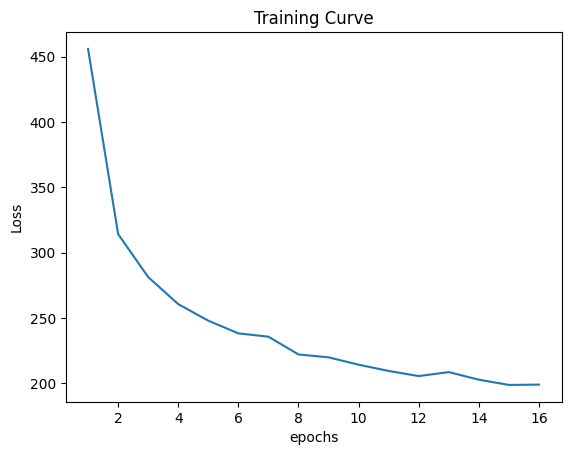

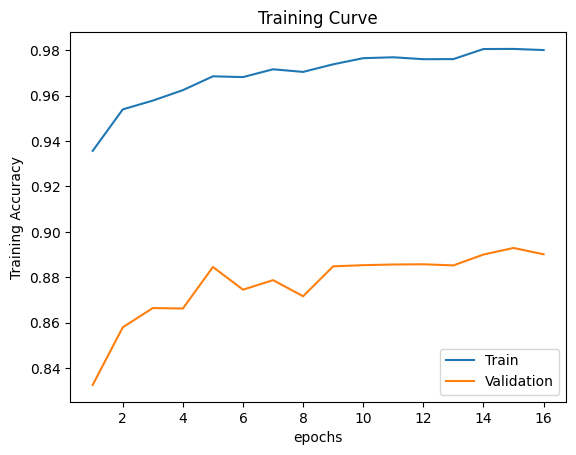

Final Training Accuracy: 0.9801666666666666
Final Validation Accuracy: 0.8901


In [70]:
train(model_shl, mnist_train, num_epochs=16)

## Comparing to deep FFN

Single Hiddden Layer FFN (model_shl):

>  Final Training Accuracy: 0.980

>  Final Validation Accuracy: 0.893

Deep FFN (model_five_layer):

>  Final Training Accuracy: 0.996

>  Final Validation Accuracy: 0.919

The deep FFN is a clearly better model with a validation accuracy that is 0.26 better. Both models have the same number of parameters apart from in a deep FFN you can also vary the number of layers in the model.

A single layer model can perform as well as a multi layer model if what they FNNs are trying to model is quite a simple function/ relationship but for more complex data like image classification, adding layers can reveal more information about the data which a single model would struggle more with. However, there is no guarantee that adding more layers will always improve accuracy and in some cases, it will actually slow the computational efficiency without offering any substantial improvements in accuracy.




